## Potential Urban Growth Area Mapping - Kurunegala District

This analysis identifies areas with **high potential for future urban development** in **Kurunegala District** using multiple scientific criteria:

### 🎯 **Analysis Methodology**

**Key Factors Analyzed:**
1. **Proximity to Existing Urban Areas** - Areas near current urban zones have higher growth potential
2. **Terrain Suitability (NDVI Analysis)** - Low vegetation areas are more suitable for development
3. **Distance from Urban Centers** - Optimal distance zones for expansion
4. **Environmental Constraints** - High vegetation areas preserved

### 📊 **Output Classifications**

**Development Potential Zones:**
- **Zone 5**: Very High Potential - Priority development areas
- **Zone 4**: High Potential - Secondary expansion zones
- **Zone 3**: Medium Potential - Long-term planning areas
- **Zone 2**: Low Potential - Minimal development suitability
- **Zone 1**: Very Low Potential - Not recommended for development
- **Zone 0**: Existing Urban or Excluded areas

### 🔧 **Requirements**

**Prerequisites:**
- ✅ Completed urbanization analysis (run `Urbanization Analysis for Kurunegala District.ipynb` first)
- ✅ Generated urban classification and NDVI maps
- ✅ Output folder: `Processed_Kurunegala_Urban/`

**This notebook uses results from the urbanization analysis to predict where future growth is most likely to occur.**

        POTENTIAL URBAN GROWTH ANALYSIS - KURUNEGALA DISTRICT         

✅ AOI loaded: 30 administrative divisions
   CRS: EPSG:4326

📁 Using Latest Files:
   Urban classification: Urban_20241226.tif
   NDVI data: NDVI_20241226.tif

📊 Data Loaded:
   Urban data shape: (3468, 2485)
   NDVI data shape: (3468, 2485)
   Current urban pixels: 2,004
   Current urban area: 1.80 km²

🔄 Calculating distance from urban areas...
   ✅ Max distance: 1086.3 pixels (32588 meters)
🔄 Calculating terrain suitability...
   ✅ Terrain suitability calculated
🔄 Calculating development potential scores...
   ✅ Potential scores calculated
🔄 Classifying potential zones...

📊 POTENTIAL ZONE DISTRIBUTION:
----------------------------------------------------------------------
   Zone 0 (No Potential/Existing Urban   ):     1.80 km² (  0.0%)
   Zone 1 (Very Low Potential            ):  1668.84 km² ( 21.5%)
   Zone 2 (Low Potential                 ):  2950.90 km² ( 38.0%)
   Zone 3 (Medium Potential              ):  

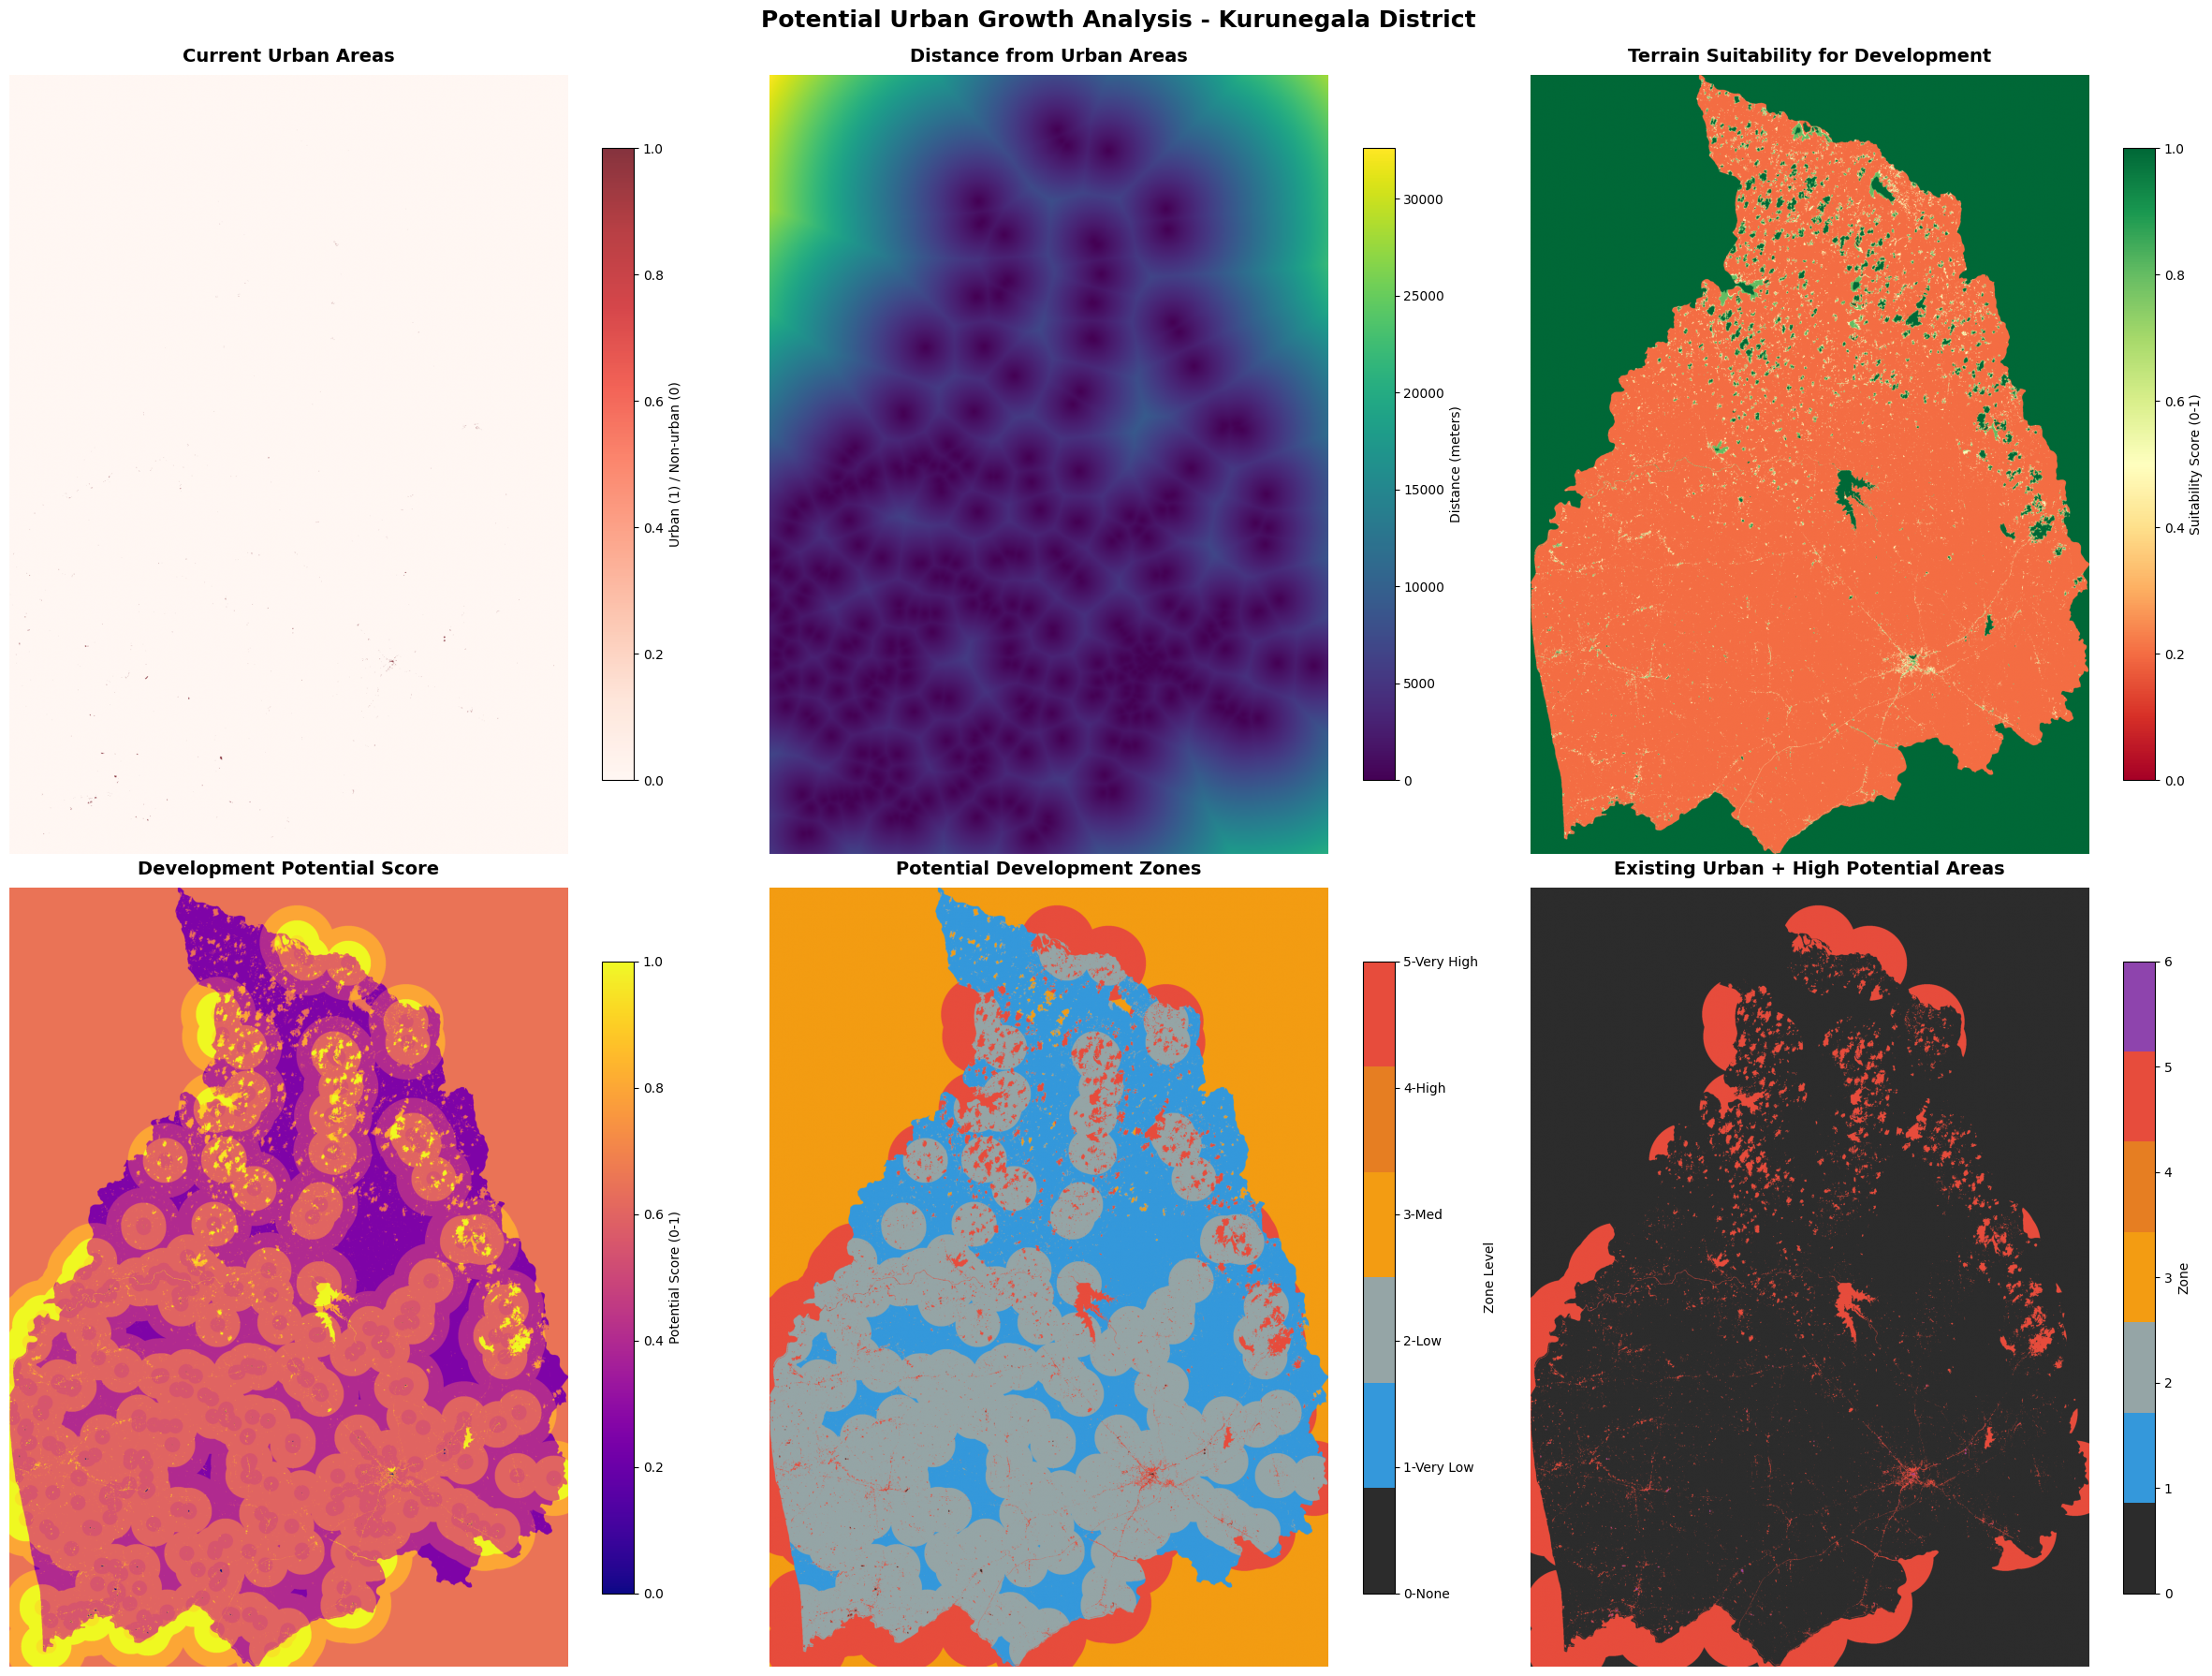

   ✅ Visualization created

       POTENTIAL GROWTH ANALYSIS SUMMARY - KURUNEGALA DISTRICT        

📏 AREA ANALYSIS (30m pixel resolution):
----------------------------------------------------------------------
   Total analyzed area: 7756.18 km²
   Current urban area: 1.80 km²
   Current urbanization: 0.02% of district

   High potential area (Zones 4-5): 810.95 km²
   Very high potential area (Zone 5): 810.95 km²

   🎯 Potential expansion capacity: 449.6x current urban area

📊 DETAILED ZONE DISTRIBUTION:
----------------------------------------------------------------------
   No Potential/Existing Urban   :     1.80 km² (  0.0%) - 2,004 pixels
   Very Low Potential            :  1668.84 km² ( 21.5%) - 1,854,266 pixels
   Low Potential                 :  2950.90 km² ( 38.0%) - 3,278,773 pixels
   Medium Potential              :  2323.69 km² ( 30.0%) - 2,581,876 pixels
   High Potential                :     0.00 km² (  0.0%) - 0 pixels
   Very High Potential           :   810.95 km² (

In [1]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# ===========================
# CONFIGURATION
# ===========================
BASE_DIR = "../.."
AOI_PATH = os.path.join(BASE_DIR, "AOI/kurunegala_District_AOI.geojson")
PROCESSED_DIR = os.path.join(BASE_DIR, "Processed_Kurunegala_Urban")  # Updated to match urbanization analysis output
OUTPUT_DIR = os.path.join(BASE_DIR, "Potential_Growth_Kurunegala")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*70)
print("POTENTIAL URBAN GROWTH ANALYSIS - KURUNEGALA DISTRICT".center(70))
print("="*70)

# LOAD AOI
aoi = gpd.read_file(AOI_PATH)
print(f"\n✅ AOI loaded: {len(aoi)} administrative divisions")
print(f"   CRS: {aoi.crs}")

# ===========================
# FIND LATEST URBAN AND NDVI FILES
# ===========================
def find_latest_files():
    """Find the most recent urban and NDVI files from urbanization analysis"""
    urban_files = []
    ndvi_files = []
    
    if not os.path.exists(PROCESSED_DIR):
        print(f"\n❌ ERROR: Processed directory not found: {PROCESSED_DIR}")
        print("   Please run 'Urbanization Analysis for Kurunegala District.ipynb' first!")
        return None, None
    
    for file in os.listdir(PROCESSED_DIR):
        if file.startswith("Urban_") and file.endswith(".tif"):
            urban_files.append(file)
        elif file.startswith("NDVI_") and file.endswith(".tif"):
            ndvi_files.append(file)
    
    if not urban_files or not ndvi_files:
        print(f"\n❌ ERROR: No urban or NDVI files found in {PROCESSED_DIR}")
        print("   Please run the urbanization analysis first to generate these files!")
        return None, None
    
    urban_files.sort()
    ndvi_files.sort()
    
    latest_urban = urban_files[-1]
    latest_ndvi = ndvi_files[-1]
    
    return latest_urban, latest_ndvi

latest_urban_file, latest_ndvi_file = find_latest_files()

if latest_urban_file is None or latest_ndvi_file is None:
    print("\n⚠️  Cannot proceed without urbanization analysis results.")
    print("   Steps to complete:")
    print("   1. Open: 'Urbanization Analysis for Kurunegala District.ipynb'")
    print("   2. Run all cells to generate urban and NDVI maps")
    print("   3. Return to this notebook and run again")
else:
    print(f"\n📁 Using Latest Files:")
    print(f"   Urban classification: {latest_urban_file}")
    print(f"   NDVI data: {latest_ndvi_file}")
    
    # ===========================
    # LOAD RASTER DATA
    # ===========================
    def load_raster_data(file_path):
        """Load raster data and return array with metadata"""
        with rasterio.open(file_path) as src:
            data = src.read(1)
            transform = src.transform
            crs = src.crs
            bounds = src.bounds
            meta = src.meta
        return data, transform, crs, bounds, meta
    
    # Load latest urban and NDVI data
    urban_path = os.path.join(PROCESSED_DIR, latest_urban_file)
    ndvi_path = os.path.join(PROCESSED_DIR, latest_ndvi_file)
    
    urban_data, transform, crs, bounds, meta = load_raster_data(urban_path)
    ndvi_data, _, _, _, _ = load_raster_data(ndvi_path)
    
    print(f"\n📊 Data Loaded:")
    print(f"   Urban data shape: {urban_data.shape}")
    print(f"   NDVI data shape: {ndvi_data.shape}")
    print(f"   Current urban pixels: {np.sum(urban_data == 1):,}")
    print(f"   Current urban area: {np.sum(urban_data == 1) * 900 / 1e6:.2f} km²")
    
    # ===========================
    # CALCULATE DISTANCE FROM EXISTING URBAN AREAS
    # ===========================
    def calculate_distance_from_urban(urban_array):
        """Calculate euclidean distance from existing urban areas (in pixels)"""
        urban_mask = (urban_array == 1)
        
        if np.sum(urban_mask) == 0:
            print("⚠️  Warning: No urban areas found in the data!")
            return np.zeros_like(urban_array, dtype=float)
        
        # Calculate distance transform (in pixels)
        distance = ndimage.distance_transform_edt(~urban_mask)
        
        return distance
    
    print("\n🔄 Calculating distance from urban areas...")
    distance_from_urban = calculate_distance_from_urban(urban_data)
    print(f"   ✅ Max distance: {distance_from_urban.max():.1f} pixels ({distance_from_urban.max() * 30:.0f} meters)")
    
    # ===========================
    # CALCULATE TERRAIN SUITABILITY
    # ===========================
    def calculate_terrain_suitability(ndvi_array):
        """
        Calculate terrain suitability based on NDVI
        Lower NDVI = more suitable for urban development
        """
        # Clip NDVI to valid range
        ndvi_norm = np.clip(ndvi_array, -1, 1)
        
        # Suitability scoring:
        # - NDVI < 0.2: Very suitable (bare soil, existing development)
        # - NDVI 0.2-0.4: Suitable (sparse vegetation)
        # - NDVI 0.4-0.6: Moderate (medium vegetation)
        # - NDVI > 0.6: Low suitability (dense vegetation/agriculture)
        
        suitability = np.zeros_like(ndvi_norm, dtype=float)
        
        # Very suitable: NDVI < 0.2
        suitability = np.where(ndvi_norm < 0.2, 1.0, suitability)
        
        # Suitable: NDVI 0.2-0.4
        suitability = np.where((ndvi_norm >= 0.2) & (ndvi_norm < 0.4), 0.8, suitability)
        
        # Moderate: NDVI 0.4-0.6
        suitability = np.where((ndvi_norm >= 0.4) & (ndvi_norm < 0.6), 0.5, suitability)
        
        # Low suitability: NDVI > 0.6 (preserve vegetation)
        suitability = np.where(ndvi_norm >= 0.6, 0.2, suitability)
        
        return suitability
    
    print("🔄 Calculating terrain suitability...")
    terrain_suitability = calculate_terrain_suitability(ndvi_data)
    print("   ✅ Terrain suitability calculated")
    
    # ===========================
    # CALCULATE DEVELOPMENT POTENTIAL SCORE
    # ===========================
    def calculate_potential_score(distance_from_urban, terrain_suitability, urban_mask):
        """
        Calculate overall development potential score
        Combines proximity to urban areas and terrain suitability
        """
        # Normalize distance (closer to urban = higher score)
        # Optimal distance: 1-3 km from existing urban areas
        optimal_distance_min = 1000 / 30  # 1 km in pixels
        optimal_distance_max = 3000 / 30  # 3 km in pixels
        
        distance_score = np.zeros_like(distance_from_urban, dtype=float)
        
        # Very close (< 1 km): High potential
        distance_score = np.where(distance_from_urban < optimal_distance_min, 0.9, distance_score)
        
        # Optimal range (1-3 km): Very high potential
        distance_score = np.where(
            (distance_from_urban >= optimal_distance_min) & 
            (distance_from_urban <= optimal_distance_max), 
            1.0, 
            distance_score
        )
        
        # Medium distance (3-5 km): Moderate potential
        distance_score = np.where(
            (distance_from_urban > optimal_distance_max) & 
            (distance_from_urban <= 5000/30),
            0.6,
            distance_score
        )
        
        # Far (> 5 km): Low potential
        distance_score = np.where(distance_from_urban > 5000/30, 0.3, distance_score)
        
        # Combine factors with weights
        weights = {
            'proximity': 0.5,    # 50% weight to proximity to existing urban
            'terrain': 0.5       # 50% weight to terrain suitability
        }
        
        potential_score = (
            weights['proximity'] * distance_score +
            weights['terrain'] * terrain_suitability
        )
        
        # Exclude already urban areas
        potential_score = np.where(urban_mask, 0, potential_score)
        
        # Handle invalid values
        potential_score = np.where(np.isnan(potential_score), 0, potential_score)
        
        return potential_score, distance_score
    
    print("🔄 Calculating development potential scores...")
    urban_mask = (urban_data == 1)
    potential_score, distance_score = calculate_potential_score(
        distance_from_urban, terrain_suitability, urban_mask
    )
    print("   ✅ Potential scores calculated")
    
    # ===========================
    # CLASSIFY POTENTIAL ZONES
    # ===========================
    def classify_potential_zones(potential_score, num_classes=5):
        """Classify areas into 5 potential development zones"""
        
        valid_scores = potential_score[potential_score > 0]
        
        if len(valid_scores) == 0:
            print("⚠️  Warning: No valid potential scores found!")
            return np.zeros_like(potential_score, dtype=int), []
        
        # Calculate percentile thresholds
        thresholds = [
            np.percentile(valid_scores, 20),
            np.percentile(valid_scores, 40),
            np.percentile(valid_scores, 60),
            np.percentile(valid_scores, 80)
        ]
        
        zones = np.zeros_like(potential_score, dtype=int)
        zones = np.where(potential_score > thresholds[3], 5, zones)  # Very High
        zones = np.where((potential_score > thresholds[2]) & (potential_score <= thresholds[3]), 4, zones)  # High
        zones = np.where((potential_score > thresholds[1]) & (potential_score <= thresholds[2]), 3, zones)  # Medium
        zones = np.where((potential_score > thresholds[0]) & (potential_score <= thresholds[1]), 2, zones)  # Low
        zones = np.where((potential_score > 0) & (potential_score <= thresholds[0]), 1, zones)  # Very Low
        
        return zones, thresholds
    
    print("🔄 Classifying potential zones...")
    potential_zones, thresholds = classify_potential_zones(potential_score)
    
    zone_labels = {
        0: 'No Potential/Existing Urban',
        1: 'Very Low Potential',
        2: 'Low Potential',
        3: 'Medium Potential',
        4: 'High Potential',
        5: 'Very High Potential'
    }
    
    print("\n📊 POTENTIAL ZONE DISTRIBUTION:")
    print("-" * 70)
    for i, label in zone_labels.items():
        count = np.sum(potential_zones == i)
        percentage = (count / potential_zones.size) * 100
        area_km2 = count * 900 / 1e6
        print(f"   Zone {i} ({label:30s}): {area_km2:8.2f} km² ({percentage:5.1f}%)")
    
    # ===========================
    # SAVE RESULTS TO GEOTIFF
    # ===========================
    def save_raster(array, output_path, transform, crs, meta):
        """Save numpy array as GeoTIFF"""
        meta_copy = meta.copy()
        meta_copy.update({
            'dtype': array.dtype,
            'count': 1,
            'transform': transform,
            'crs': crs
        })
        
        with rasterio.open(output_path, 'w', **meta_copy) as dst:
            dst.write(array, 1)
    
    print("\n💾 Saving results...")
    save_raster(potential_score.astype(np.float32), 
               os.path.join(OUTPUT_DIR, "Kurunegala_Potential_Score.tif"), transform, crs, meta)
    save_raster(potential_zones.astype(np.uint8), 
               os.path.join(OUTPUT_DIR, "Kurunegala_Potential_Zones.tif"), transform, crs, meta)
    save_raster(distance_score.astype(np.float32), 
               os.path.join(OUTPUT_DIR, "Kurunegala_Proximity_Score.tif"), transform, crs, meta)
    save_raster(terrain_suitability.astype(np.float32), 
               os.path.join(OUTPUT_DIR, "Kurunegala_Terrain_Suitability.tif"), transform, crs, meta)
    print("   ✅ GeoTIFF files saved")
    
    # ===========================
    # VISUALIZATION
    # ===========================
    print("\n📊 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 18))
    fig.suptitle('Potential Urban Growth Analysis - Kurunegala District', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    # 1. Current Urban Areas
    im1 = axes[0, 0].imshow(urban_data, cmap='Reds', alpha=0.8)
    axes[0, 0].set_title('Current Urban Areas', fontsize=14, fontweight='bold', pad=10)
    axes[0, 0].set_xlabel('Pixel X')
    axes[0, 0].set_ylabel('Pixel Y')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], label='Urban (1) / Non-urban (0)', shrink=0.8)
    
    # 2. Distance from Urban
    im2 = axes[0, 1].imshow(distance_from_urban * 30, cmap='viridis')  # Convert to meters
    axes[0, 1].set_title('Distance from Urban Areas', fontsize=14, fontweight='bold', pad=10)
    axes[0, 1].set_xlabel('Pixel X')
    axes[0, 1].set_ylabel('Pixel Y')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], label='Distance (meters)', shrink=0.8)
    
    # 3. Terrain Suitability
    im3 = axes[0, 2].imshow(terrain_suitability, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0, 2].set_title('Terrain Suitability for Development', fontsize=14, fontweight='bold', pad=10)
    axes[0, 2].set_xlabel('Pixel X')
    axes[0, 2].set_ylabel('Pixel Y')
    axes[0, 2].axis('off')
    plt.colorbar(im3, ax=axes[0, 2], label='Suitability Score (0-1)', shrink=0.8)
    
    # 4. Development Potential Score
    im4 = axes[1, 0].imshow(potential_score, cmap='plasma', vmin=0, vmax=1)
    axes[1, 0].set_title('Development Potential Score', fontsize=14, fontweight='bold', pad=10)
    axes[1, 0].set_xlabel('Pixel X')
    axes[1, 0].set_ylabel('Pixel Y')
    axes[1, 0].axis('off')
    plt.colorbar(im4, ax=axes[1, 0], label='Potential Score (0-1)', shrink=0.8)
    
    # 5. Potential Zones
    colors = ['#2c2c2c', '#3498db', '#95a5a6', '#f39c12', '#e67e22', '#e74c3c']
    cmap_zones = plt.matplotlib.colors.ListedColormap(colors)
    im5 = axes[1, 1].imshow(potential_zones, cmap=cmap_zones, vmin=0, vmax=5)
    axes[1, 1].set_title('Potential Development Zones', fontsize=14, fontweight='bold', pad=10)
    axes[1, 1].set_xlabel('Pixel X')
    axes[1, 1].set_ylabel('Pixel Y')
    axes[1, 1].axis('off')
    cbar5 = plt.colorbar(im5, ax=axes[1, 1], shrink=0.8, ticks=range(6))
    cbar5.set_label('Zone Level')
    cbar5.ax.set_yticklabels(['0-None', '1-Very Low', '2-Low', '3-Med', '4-High', '5-Very High'])
    
    # 6. Combined View (Urban + High Potential)
    combined = np.zeros_like(potential_zones)
    combined = np.where(urban_data == 1, 6, combined)  # Existing urban
    combined = np.where((potential_zones >= 4) & (urban_data == 0), potential_zones, combined)
    
    colors_combined = ['#2c2c2c', '#3498db', '#95a5a6', '#f39c12', '#e67e22', '#e74c3c', '#8e44ad']
    cmap_combined = plt.matplotlib.colors.ListedColormap(colors_combined)
    im6 = axes[1, 2].imshow(combined, cmap=cmap_combined, vmin=0, vmax=6)
    axes[1, 2].set_title('Existing Urban + High Potential Areas', fontsize=14, fontweight='bold', pad=10)
    axes[1, 2].set_xlabel('Pixel X')
    axes[1, 2].set_ylabel('Pixel Y')
    axes[1, 2].axis('off')
    cbar6 = plt.colorbar(im6, ax=axes[1, 2], shrink=0.8)
    cbar6.set_label('Zone')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "Kurunegala_Potential_Growth_Analysis.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("   ✅ Visualization created")
    
    # ===========================
    # STATISTICS AND SUMMARY
    # ===========================
    print("\n" + "="*70)
    print("POTENTIAL GROWTH ANALYSIS SUMMARY - KURUNEGALA DISTRICT".center(70))
    print("="*70)
    
    # Calculate areas (30m pixel resolution)
    pixel_area_km2 = (30 * 30) / 1e6  # 30m x 30m pixel in km²
    
    print(f"\n📏 AREA ANALYSIS (30m pixel resolution):")
    print("-" * 70)
    total_area = potential_zones.size * pixel_area_km2
    print(f"   Total analyzed area: {total_area:.2f} km²")
    
    current_urban_area = np.sum(urban_data == 1) * pixel_area_km2
    print(f"   Current urban area: {current_urban_area:.2f} km²")
    print(f"   Current urbanization: {(current_urban_area/total_area)*100:.2f}% of district")
    
    high_potential_area = np.sum(potential_zones >= 4) * pixel_area_km2
    print(f"\n   High potential area (Zones 4-5): {high_potential_area:.2f} km²")
    
    very_high_potential_area = np.sum(potential_zones == 5) * pixel_area_km2
    print(f"   Very high potential area (Zone 5): {very_high_potential_area:.2f} km²")
    
    expansion_ratio = high_potential_area / current_urban_area if current_urban_area > 0 else 0
    print(f"\n   🎯 Potential expansion capacity: {expansion_ratio:.1f}x current urban area")
    
    # Zone distribution details
    print(f"\n📊 DETAILED ZONE DISTRIBUTION:")
    print("-" * 70)
    for zone_id, label in zone_labels.items():
        area = np.sum(potential_zones == zone_id) * pixel_area_km2
        percentage = (np.sum(potential_zones == zone_id) / potential_zones.size) * 100
        pixels = np.sum(potential_zones == zone_id)
        print(f"   {label:30s}: {area:8.2f} km² ({percentage:5.1f}%) - {pixels:,} pixels")
    
    # ===========================
    # DEVELOPMENT RECOMMENDATIONS
    # ===========================
    print(f"\n" + "="*70)
    print("URBAN DEVELOPMENT RECOMMENDATIONS".center(70))
    print("="*70)
    
    print(f"""
🎯 PRIORITY DEVELOPMENT AREAS:
   • Zone 5 (Very High Potential): {very_high_potential_area:.2f} km²
     → Immediate development focus
     → Located 1-3 km from existing urban areas
     → Low vegetation, high terrain suitability
   
   • Zone 4 (High Potential): {np.sum(potential_zones == 4) * pixel_area_km2:.2f} km²
     → Secondary development phase (2-5 years)
     → Good connectivity potential
     → Moderate infrastructure requirements

📍 DEVELOPMENT PHASING STRATEGY:
   Phase 1 (0-5 years):   Focus on Zone 5 areas
   Phase 2 (5-10 years):  Expand to Zone 4 areas  
   Phase 3 (10-20 years): Consider Zone 3 areas for long-term growth

🏗️ INFRASTRUCTURE PLANNING PRIORITIES:
   1. Road networks to connect Zone 5 areas to existing urban centers
   2. Utility extensions (water, electricity) to high potential zones
   3. Public transport corridors along major growth axes
   4. Green buffer zones to separate development from high-vegetation areas

🌳 ENVIRONMENTAL CONSIDERATIONS:
   • Preserve Zone 1-2 areas with high vegetation (NDVI > 0.6)
   • Maintain ecological corridors
   • Implement sustainable development practices in Zone 3-4 areas
   • Protected areas: {np.sum(ndvi_data > 0.6) * pixel_area_km2:.2f} km² (dense vegetation)

📊 GROWTH CAPACITY ANALYSIS:
   • Current urban coverage: {current_urban_area:.2f} km² ({(current_urban_area/total_area)*100:.1f}%)
   • High potential for growth: {high_potential_area:.2f} km² ({(high_potential_area/total_area)*100:.1f}%)
   • Maximum expansion potential: {expansion_ratio:.1f}x current urban size
   • Sustainable growth target: {high_potential_area * 0.7:.2f} km² (70% of high potential areas)

⚠️ PLANNING CONSIDERATIONS:
   • Balance urban expansion with agricultural preservation
   • Consider flood risk in low-lying areas
   • Ensure adequate green space (minimum 15% in new developments)
   • Plan for climate resilience and sustainable infrastructure
""")
    
    print("="*70)
    print("✅ POTENTIAL GROWTH AREA ANALYSIS COMPLETED!".center(70))
    print("="*70)
    print(f"\n📁 Results Location: {OUTPUT_DIR}")
    print("\n📄 Generated Files:")
    print("   • Kurunegala_Potential_Growth_Analysis.png - Comprehensive visualization")
    print("   • Kurunegala_Potential_Score.tif - Development potential scores (0-1)")
    print("   • Kurunegala_Potential_Zones.tif - Classified zones (0-5)")
    print("   • Kurunegala_Proximity_Score.tif - Proximity to urban areas")
    print("   • Kurunegala_Terrain_Suitability.tif - Terrain suitability scores")
    print("\n💡 Next Steps:")
    print("   • Review the generated maps in GIS software (QGIS, ArcGIS)")
    print("   • Validate high potential zones with ground truth data")
    print("   • Integrate with urban master plans and zoning regulations")
    print("   • Conduct detailed feasibility studies for Zone 5 areas")
    print("="*70)

## How to View and Use Generated GeoTIFF Files

The analysis generates several **GeoTIFF (.tif)** files that can be viewed and analyzed in multiple ways:

### 📊 **Method 1: View in Jupyter (Quick Preview)**
Run the cells below to display the generated maps directly in this notebook.

### 🗺️ **Method 2: Open in GIS Software (Recommended for Analysis)**
- **QGIS** (Free): https://qgis.org/
- **ArcGIS** (Commercial)
- **Google Earth Pro** (Free, limited support)

### 📁 **Generated Files:**
1. `Kurunegala_Potential_Score.tif` - Overall development potential (0-1 scale)
2. `Kurunegala_Potential_Zones.tif` - Classified zones (0-5)
3. `Kurunegala_Proximity_Score.tif` - Distance-based scores
4. `Kurunegala_Terrain_Suitability.tif` - Land suitability scores

              VIEWING GENERATED GEOTIFF FILES               



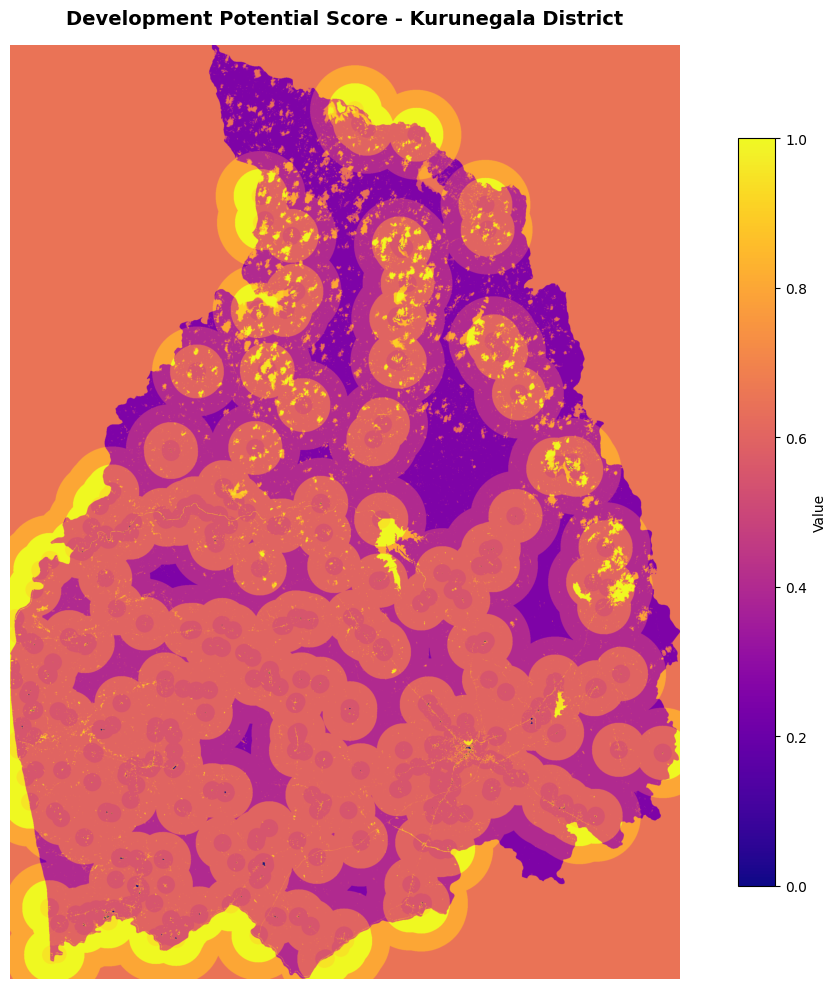

📄 File: Kurunegala_Potential_Score.tif
   Shape: 2485 x 3468 pixels
   Data type: float32
   Value range: 0.000 to 1.000
   Valid pixels: 8,617,980
------------------------------------------------------------



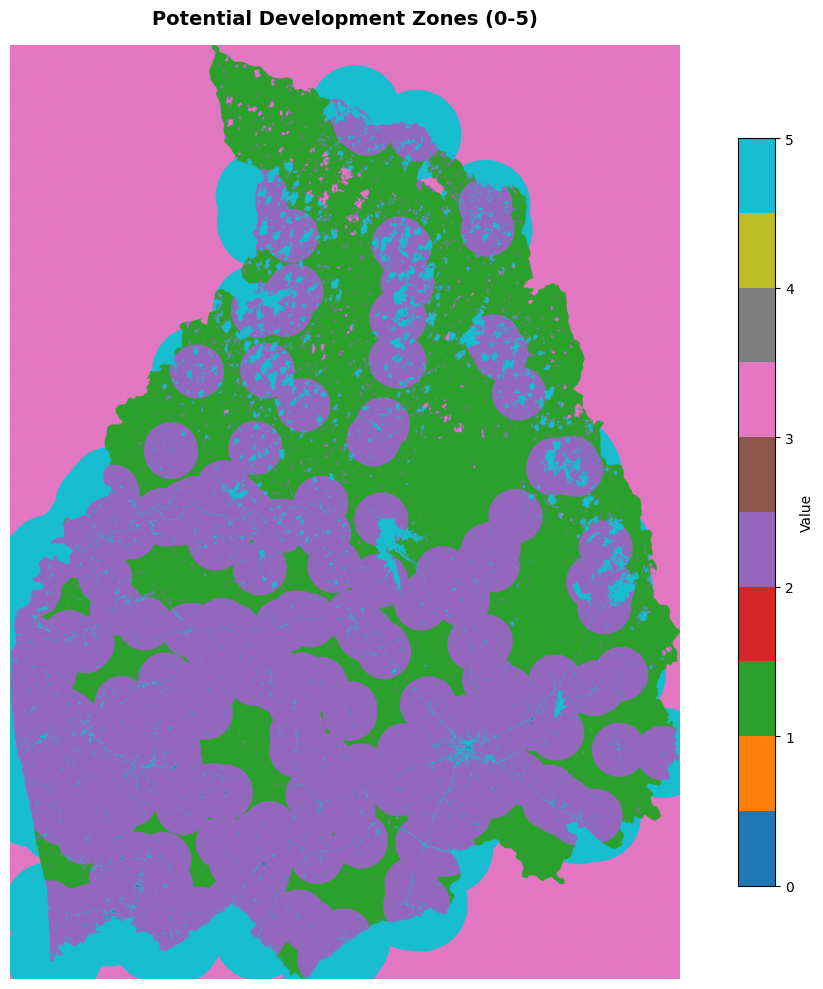

📄 File: Kurunegala_Potential_Zones.tif
   Shape: 2485 x 3468 pixels
   Data type: uint8
   Value range: 0.000 to 5.000
   Valid pixels: 8,617,980
------------------------------------------------------------



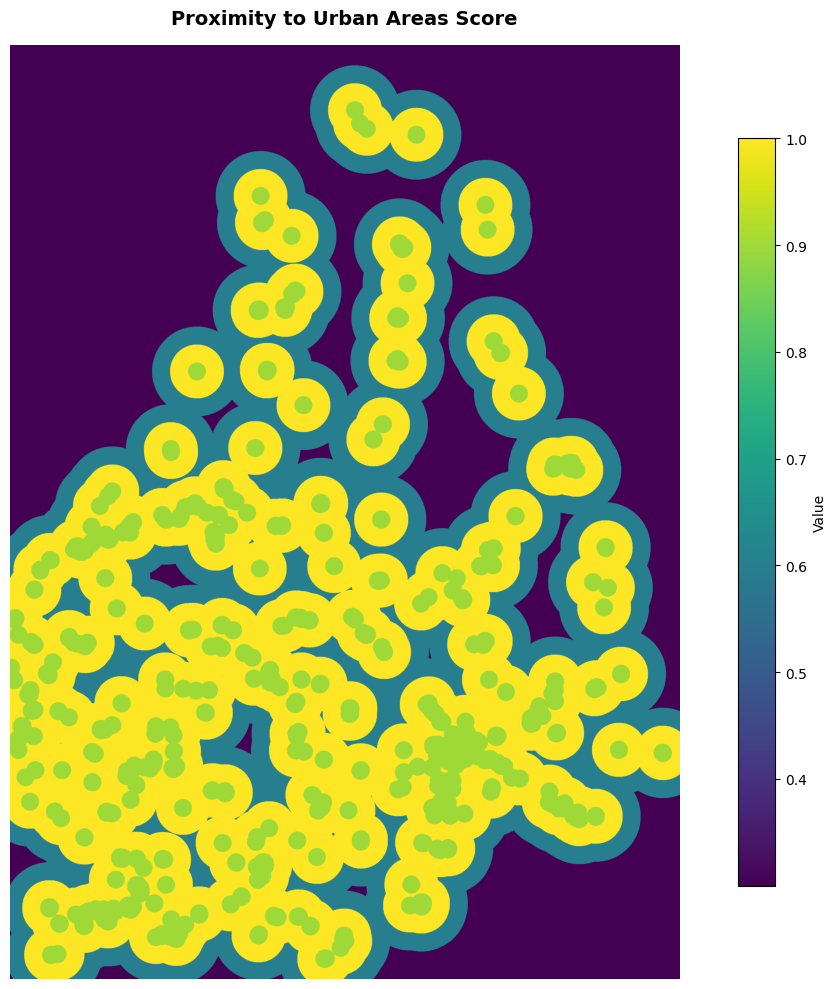

📄 File: Kurunegala_Proximity_Score.tif
   Shape: 2485 x 3468 pixels
   Data type: float32
   Value range: 0.300 to 1.000
   Valid pixels: 8,617,980
------------------------------------------------------------



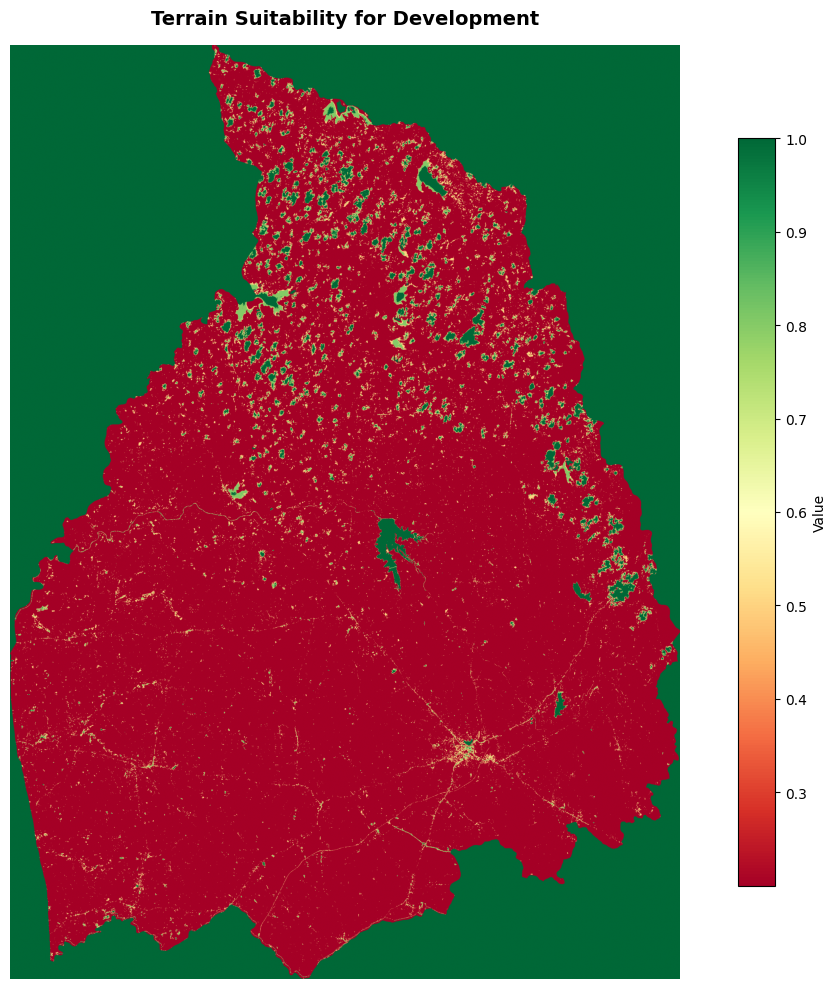

📄 File: Kurunegala_Terrain_Suitability.tif
   Shape: 2485 x 3468 pixels
   Data type: float32
   Value range: 0.200 to 1.000
   Valid pixels: 8,617,980
------------------------------------------------------------



In [2]:
# DISPLAY GENERATED TIF FILES IN JUPYTER
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

OUTPUT_DIR = "../../Potential_Growth_Kurunegala"

def display_tif(file_path, title="", cmap='viridis'):
    """Display a GeoTIFF file with matplotlib"""
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            
        plt.figure(figsize=(12, 10))
        im = plt.imshow(data, cmap=cmap)
        plt.colorbar(im, label='Value', shrink=0.8)
        plt.title(title, fontsize=14, fontweight='bold', pad=15)
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"📄 File: {os.path.basename(file_path)}")
        print(f"   Shape: {data.shape[1]} x {data.shape[0]} pixels")
        print(f"   Data type: {data.dtype}")
        print(f"   Value range: {np.nanmin(data):.3f} to {np.nanmax(data):.3f}")
        print(f"   Valid pixels: {np.sum(~np.isnan(data)):,}")
        print("-" * 60 + "\n")
    else:
        print(f"❌ File not found: {file_path}")
        print(f"   Make sure you've run the analysis in the previous cell first!\n")

# List of TIF files to display
tif_files = [
    ("Kurunegala_Potential_Score.tif", "Development Potential Score - Kurunegala District", "plasma"),
    ("Kurunegala_Potential_Zones.tif", "Potential Development Zones (0-5)", "tab10"),
    ("Kurunegala_Proximity_Score.tif", "Proximity to Urban Areas Score", "viridis"),
    ("Kurunegala_Terrain_Suitability.tif", "Terrain Suitability for Development", "RdYlGn")
]

print("="*60)
print("VIEWING GENERATED GEOTIFF FILES".center(60))
print("="*60 + "\n")

for filename, title, colormap in tif_files:
    file_path = os.path.join(OUTPUT_DIR, filename)
    display_tif(file_path, title, colormap)

In [3]:
# EXTRACT GEOGRAPHIC INFORMATION FROM TIF FILES
import rasterio
import numpy as np
import os

OUTPUT_DIR = "../../Potential_Growth_Kurunegala"

def get_tif_info(file_path):
    """Extract and display geographic metadata from GeoTIFF"""
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            transform = src.transform
            crs = src.crs
            bounds = src.bounds
            
            print(f"📍 FILE: {os.path.basename(file_path)}")
            print(f"   Dimensions: {src.width} x {src.height} pixels")
            print(f"   CRS: {crs}")
            print(f"   Bounds (lon, lat):")
            print(f"      West:  {bounds.left:.6f}°")
            print(f"      East:  {bounds.right:.6f}°")
            print(f"      South: {bounds.bottom:.6f}°")
            print(f"      North: {bounds.top:.6f}°")
            print(f"   Pixel Size: {transform.a:.6f}° x {abs(transform.e):.6f}°")
            print(f"   Data Statistics:")
            print(f"      Min: {np.nanmin(data):.4f}")
            print(f"      Max: {np.nanmax(data):.4f}")
            print(f"      Mean: {np.nanmean(data):.4f}")
            print(f"      Std: {np.nanstd(data):.4f}")
            print("-" * 60 + "\n")
            
            return data, transform, crs, bounds
    else:
        print(f"❌ File not found: {file_path}\n")
        return None, None, None, None

print("="*60)
print("GEOGRAPHIC INFORMATION - KURUNEGALA GROWTH ANALYSIS".center(60))
print("="*60 + "\n")

# Get info for all generated TIF files
tif_files = [
    "Kurunegala_Potential_Score.tif",
    "Kurunegala_Potential_Zones.tif",
    "Kurunegala_Proximity_Score.tif",
    "Kurunegala_Terrain_Suitability.tif"
]

for filename in tif_files:
    file_path = os.path.join(OUTPUT_DIR, filename)
    get_tif_info(file_path)

print("="*60)
print("💡 TIP: Open these files in QGIS for advanced analysis!".center(60))
print("="*60)

    GEOGRAPHIC INFORMATION - KURUNEGALA GROWTH ANALYSIS     

📍 FILE: Kurunegala_Potential_Score.tif
   Dimensions: 2485 x 3468 pixels
   CRS: EPSG:32644
   Bounds (lon, lat):
      West:  378675.000000°
      East:  453225.000000°
      South: 802095.000000°
      North: 906135.000000°
   Pixel Size: 30.000000° x 30.000000°
   Data Statistics:
      Min: 0.0000
      Max: 1.0000
      Mean: 0.5851
      Std: 0.1524
------------------------------------------------------------

📍 FILE: Kurunegala_Potential_Zones.tif
   Dimensions: 2485 x 3468 pixels
   CRS: EPSG:32644
   Bounds (lon, lat):
      West:  378675.000000°
      East:  453225.000000°
      South: 802095.000000°
      North: 906135.000000°
   Pixel Size: 30.000000° x 30.000000°
   Data Statistics:
      Min: 0.0000
      Max: 5.0000
      Mean: 2.3976
      Std: 1.1396
------------------------------------------------------------

📍 FILE: Kurunegala_Proximity_Score.tif
   Dimensions: 2485 x 3468 pixels
   CRS: EPSG:32644
   Bou